In [1]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import shap
import tensorflow as tf

/Users/andres/miniconda3/envs/tfenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-03-11 18:40:36.231498: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# The features names according to the published papers
feature_names = ['PatientAge', 'CT', 'AnyBleeding', 'Diarrhoea', 'Breathlessness', 'SwallowingProblems']

# The original variable names in the data file
out_var = 'S7.FinalStatus'
orig_var_names = {
  'PatientAge':'AD.Age',
  'CT':'Lab.CtNP.D1',
  'AnyBleeding':'S2.Bleeding',
  'Diarrhoea':'S2.Diarrhea',
  'Breathlessness':'S2.DifficultyBreathing', 
  'SwallowingProblems':'S2.DifficultySwallowing'
}

In [3]:
# Loading the data
drc_data_file = 'data.csv'
drc_data = pd.read_csv(drc_data_file, na_values="\\N")

columns = [out_var] + [orig_var_names[feat] for feat in feature_names]

test_data = drc_data[columns]
complete_data = test_data.dropna()
complete_data

,S7.FinalStatus,AD.Age,Lab.CtNP.D1,S2.Bleeding,S2.Diarrhea,S2.DifficultyBreathing,S2.DifficultySwallowing
0,0.0,13.000,27.2,0,1,0,0
1,1.0,14.000,18.5,1,1,1,1
2,1.0,5.000,18.1,1,1,1,0
3,0.0,0.250,18.7,0,0,0,0
4,0.0,8.000,25.4,0,1,1,1
...,...,...,...,...,...,...,...
67,0.0,7.000,27.3,0,0,0,0
69,1.0,17.000,20.5,0,0,0,0
70,0.0,0.167,22.1,0,0,0,0
71,0.0,1.000,18.5,0,0,0,0


In [4]:
all_feat_values = complete_data.values
all_feat_values.shape

(67, 7)

In [5]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path='model.tflite')

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Allocate tensors
interpreter.allocate_tensors()

INFO: Initialized TensorFlow Lite runtime.
INFO: Applying 1 TensorFlow Lite delegate(s) lazily.
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
INFO: XNNPack weight cache not enabled.
VERBOSE: Replacing 23 out of 39 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 5 partitions for the whole graph.
INFO: Successfully applied the default TensorFlow Lite delegate indexed at 0.
 *NOTE*: because a delegate has been applied, the precision of computations should be unchanged, but the exact output tensor values may have changed. If such output values are checked in your code, like in your tests etc., please consider increasing error tolerance for the check.


In [6]:
input_details

[{'name': 'serving_default_input_feats_2:0',
  'index': 0,
  'shape': array([1, 1], dtype=int32),
  'shape_signature': array([-1,  1], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}},
 {'name': 'serving_default_input_feats_3-6:0',
  'index': 1,
  'shape': array([1, 4], dtype=int32),
  'shape_signature': array([-1,  4], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}},
 {'name': 'serving_default_input_feats_1:0',
  'index': 2,
  'shape': array([1, 1], dtype=int32),
  'shape_signature': array([-1,  1], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dty

In [7]:
output_details

[{'name': 'StatefulPartitionedCall_1:0',
  'index': 61,
  'shape': array([1, 1], dtype=int32),
  'shape_signature': array([-1,  1], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [8]:
# This function should be provided to shap.KernelExplainer:
# https://shap.readthedocs.io/en/latest/generated/shap.KernelExplainer.html 
# User supplied function that takes a matrix of samples (# samples x # features) and computes the output of the model for those samples. 
# The output can be a vector (# samples) or a matrix (# samples x # model outputs).
def tflite_predict(input_data):
    outputs = []
    for row in input_data:
        for input_detail in input_details:
            name = input_detail['name']
            v = name[name.find('input_feats')+12:-2]
            idx = v.split('-')
            if len(idx) == 1:
                data = row[int(idx[0]):int(idx[0])+1]
            elif len(idx) == 2:
                data = row[int(idx[0]):int(idx[1])+1]

            input_shape = input_detail['shape']
            input_type = input_detail['dtype']
            input_shaped_data = np.array(data).reshape(input_shape).astype(input_type)
            interpreter.set_tensor(input_detail['index'], input_shaped_data)
        
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])
        outputs.append(output_data.flatten())

    return np.array(outputs)  # Flatten the output for Shap  

In [9]:
tflite_predict(all_feat_values)

array([[0.16258578],
       [0.74186057],
       [0.8503953 ],
       [0.91843873],
       [0.40652493],
       [0.8985175 ],
       [0.72206444],
       [0.3371445 ],
       [0.9005372 ],
       [0.8962692 ],
       [0.3590634 ],
       [0.6111052 ],
       [0.5051973 ],
       [0.3384354 ],
       [0.26840815],
       [0.4605284 ],
       [0.7065915 ],
       [0.7817771 ],
       [0.6610525 ],
       [0.11222844],
       [0.9468249 ],
       [0.99277097],
       [0.55140316],
       [0.4882183 ],
       [0.5953901 ],
       [0.85564446],
       [0.8211093 ],
       [0.63375354],
       [0.7673809 ],
       [0.79039425],
       [0.30830416],
       [0.6440413 ],
       [0.2331508 ],
       [0.38836384],
       [0.23489113],
       [0.64111894],
       [0.76323146],
       [0.83276814],
       [0.18776023],
       [0.5441523 ],
       [0.92606306],
       [0.12045917],
       [0.2380878 ],
       [0.7921318 ],
       [0.8288827 ],
       [0.7837022 ],
       [0.5623387 ],
       [0.966

In [10]:
explainer = shap.KernelExplainer(tflite_predict, all_feat_values)

In [49]:
# Pick an instance to calculate the shap plot
idx = 25

instance = all_feat_values[idx]
shap_values = explainer.shap_values(instance)
shap_values[1:]

array([[ 0.24187141],
       [-0.00653361],
       [-0.0120395 ],
       [ 0.02443855],
       [-0.00868925],
       [-0.01131197]])

In [50]:
instance[0] = 16

instance[3] = 1
instance[4] = 0
instance[5] = 1
instance[6] = 0

shap_values = explainer.shap_values(instance)

In [51]:
feature_names = complete_data.columns[1:].tolist()  # Get feature names from DataFrame
explanation = shap.Explanation(
    values=shap_values[1:].reshape(1, 6)[0], # Need to reshape to it matches the instance dimensions
    base_values=explainer.expected_value[0], # correct base_values for single output models
    feature_names=feature_names,
    data=np.array(instance)  # Convert instance to NumPy array
)
explanation

.values =
array([ 0.22667478, -0.00427789,  0.03261825, -0.01313636,  0.04085051,
       -0.01054864])

.base_values =
0.6280831687930805

.data =
array([16. ,  1. , 21.7,  1. ,  0. ,  1. ,  0. ])

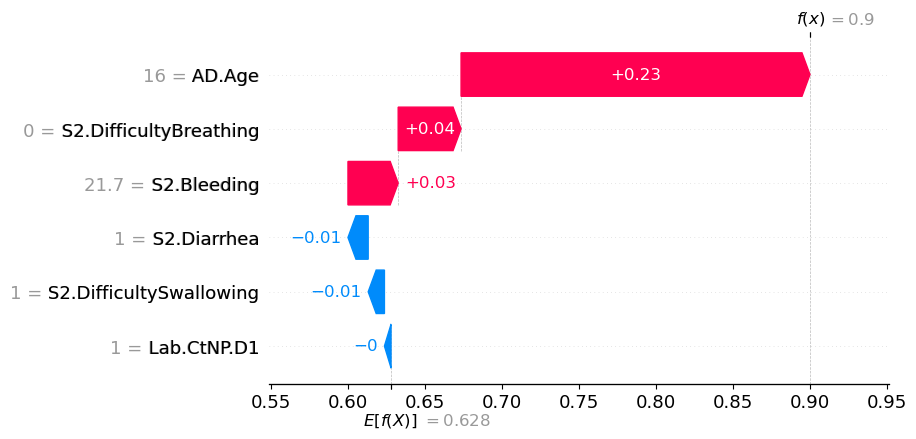

In [52]:
shap.plots.waterfall(explanation)